## BTC/USD Forecasting with LSTMs

##### Short dataset description
Dataset was sourced from : https://www.cryptodatadownload.com/data/bitfinex/. It cointains hourly historical data of the pair BTC/USD. Data are retrieved from Bitfinex (crypto cex). The columns of the data contain :

1) **open** price of the hourly candle
2) **close** price of the hourly candle
3) **low** price (min) of the hourly candle
4) **high** price (max) of the hourly candle
5) **volume** volume during the candle denominated in the respective currency (**btc/usd**)
6) **symbol** --> btc/usd
7) **unix timestamp**
8) **date**

In [157]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from stockstats import wrap
from stockstats import StockDataFrame

#### Read the data

In [158]:
df = pd.read_csv('Bitfinex_BTCUSD_1h.csv')
df['date'] = pd.to_datetime(df['date'])
#df['year'] = df['date'].dt.year
#df['month'] = df['date'].dt.month
#df['day'] = df['date'].dt.day
#df['hour'] = df['date'].dt.hour
df = df.drop(["unix", "symbol"], axis = 1)
df = df.sort_values(by='date')

In [159]:
df.head()

,date,open,high,low,close,Volume USD,Volume BTC
44624,2018-05-15 06:00:00,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35
44623,2018-05-15 07:00:00,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97
44622,2018-05-15 08:00:00,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31
44621,2018-05-15 09:00:00,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55
44620,2018-05-15 10:00:00,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08


### Insert trading indicators

In [160]:
df2 = df.copy(deep=True)
df2['volume'] = df2['Volume BTC']
df2 = wrap(df2, 'date')

In [161]:
# Calculate Simple Moving Average (SMA) with a window of 10 hours
df2['close_10_sma'] = df2['close_10_sma']

# Calculate Weighted Moving Average (WMA) with a window of 10 hours
df2['wma_10'] = df2['vwma_10']

# Calculate Relative Strength Index (RSI) with a window of 10 hours
df2['rsi_10'] = df2['rsi_10']

# Calculate Price Rate of Change (ROC) with a window of 10 hours
df2['open_10_roc'] = df2['open_10_roc']
# Calculate Momentum (Mo) with a window of 10 hours
df2['mo_10'] = df2['cmo_10']

# Calculate On Balance Volume (OBV)
df2['bop'] = df2['bop']

# Calculate Log Return
df2['log_return'] = df2['log-ret']

# Calculate Max in Range
df2['max_in_range'] = df2['close_-1~0_max']

# Calculate Min in Range
df2['min_in_range'] = df2['close_-1~0_max']

# Calculate Middle = (close + high + low) / 3
df2['middle'] = df2['middle']

# Calculate Exponential Moving Average (SMA) with a window of 10 hours
df2['close_10_ema'] = df2['close_10_ema']

# Calculate MTSD with a window of 10 hours
df2['close_10_mstd'] = df2['close_10_mstd']

# Calculate MVAR with a window of 10 hours
df2['close_10_mvar'] = df2['close_10_mvar']

# Calculate RSV with a window of 10 hours
df2['rsv_10'] = df2['rsv_10']


# Calculate RSI with a window of 10 hours
df2['rsi_10'] = df2['rsi_10']
# Calculate KDJ with a window of 10 hours
df2['kdjk_10'] = df2['kdjk_10']
df2['kdjj_10'] = df2['kdjj_10']
df2['kdjd_10'] = df2['kdjd_10']

# Calculate the bollinger window
df2['boll'] = df2['boll_1']


# calculate macd with a window of 5 hours
df2['macd'] = df2['macd_5']

#df2['cr'] = df2['cr_1']
df2['wr'] = df2['wr_1']
df2['cci'] = df2['cci_1']
df2['tr'] = df2['tr_1']
df2['atr'] = df2['atr_1']
df2['dma'] = df2['dma_1']
df2['pdmi'] = df2['pdi_1']
df2['admi'] = df2['adx']
df2['ardmi'] = df2['adxr']
df2['trix'] = df2['trix_10']
df2['tema'] = df2['tema_10']
df2['vr'] = df2['vr_1']

In [162]:
df2.init_all()

/usr/local/lib/python3.11/dist-packages/stockstats.py:834: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self[meta.name] = pdi
/usr/local/lib/python3.11/dist-packages/stockstats.py:1640: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self[meta.name] = self._pgo(meta.int)
/usr/local/lib/python3.11/dist-packages/stockstats.py:1663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [163]:
df2.head()

,open,high,low,close,volume usd,volume btc,volume,close_10_sma,vwma_10,wma_10,...,ker,mfi,ndi,pdi,pgo,psl,rsi,rsv,stochrsi,vwma
date,,,,,,,,,,,,,,,,,,,,,
2018-05-15 06:00:00,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35,1026.35,8739.000000,8748.966667,8748.966667,...,0.000000,0.5,-0.000000,0.000000,0.000000,0.000000,NaN,30.857875,NaN,8748.966667
2018-05-15 07:00:00,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97,261.97,8741.000000,8746.946799,8746.946799,...,1.000000,0.5,-0.000000,0.000000,0.036180,8.333333,100.000000,35.979513,NaN,8746.946799
2018-05-15 08:00:00,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31,1023.31,8735.233333,8729.115632,8729.115632,...,0.656652,0.5,34.751866,0.000000,-0.168360,8.333333,16.139044,50.429185,0.000000,8729.115632
2018-05-15 09:00:00,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55,235.55,8728.450000,8727.875023,8727.875023,...,0.794344,0.5,28.786566,0.000000,-0.346420,8.333333,9.329028,39.270386,0.000000,8727.875023
2018-05-15 10:00:00,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08,1969.08,8739.640000,8750.005541,8750.005541,...,0.394097,0.5,15.925134,32.943126,0.525752,16.666667,71.863748,64.790123,68.968843,8750.005541


In [164]:
# Count the nulls in each column
null_counts = df2.isnull().sum()
print("Null Counts:")
for column_name, count in null_counts.items():
    if count != 0 and count > 1:
        print(f"Column '{column_name}': {count} null values")

Null Counts:
Column 'bop': 27 null values
Column 'boll_ub_1': 44625 null values
Column 'boll_lb_1': 44625 null values
Column 'wr_1': 27 null values
Column 'cci_1': 44625 null values
Column 'pdi_1': 24 null values
Column 'pdmi': 24 null values
Column 'dx': 2 null values
Column 'adx': 2 null values
Column 'adxr': 2 null values
Column 'admi': 2 null values
Column 'ardmi': 2 null values
Column 'vr_1': 21 null values
Column 'stochrsi': 2 null values


In [165]:
df2.columns[df2.isnull().any()]

Index(['rsi_10', 'bop', 'close_10_mstd', 'close_10_mvar', 'boll_ub_1',
       'boll_lb_1', 'wr_1', 'cci_1', 'cci', 'pdi_1', 'pdmi', 'dx', 'adx',
       'adxr', 'admi', 'ardmi', 'vr_1', 'rate', 'boll_ub', 'boll_lb', 'wt1',
       'wt2', 'rsi', 'stochrsi'],
      dtype='object')

In [166]:
columns_with_nulls = df2.columns[df2.isnull().any()]
#df2 = df2.drop(columns_with_nulls, axis = 1)
columns_to_drop = ['boll_ub_1', 'boll_lb_1', 'cci', 'cci_1', 'cr_1', 'vr_1', 'cr','vr']

# Retaining only columns in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in df2.columns]

df2 = df2.drop(columns_to_drop, axis=1)

In [167]:
df2 = df2.fillna(method='bfill')
df2 = df2.fillna(method='ffill')

/tmp/ipykernel_3394/3410108221.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2 = df2.fillna(method='bfill')
/tmp/ipykernel_3394/3410108221.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2 = df2.fillna(method='ffill')


In [168]:
inf_counts = (df2 == np.inf).sum()

print("Null and Infinite Value Counts:")
for column_name in df2.columns:
    inf_count = inf_counts[column_name]
    
    if inf_count != 0:
        print(f"Column '{column_name}': {inf_count} inf values")

Null and Infinite Value Counts:


In [169]:
for col in df2.columns:
    df[col] = df2[col].values

/tmp/ipykernel_3394/1983232393.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = df2[col].values
/tmp/ipykernel_3394/1983232393.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = df2[col].values
/tmp/ipykernel_3394/1983232393.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

In [170]:
df.head()

,date,open,high,low,close,Volume USD,Volume BTC,volume usd,volume btc,volume,...,ker,mfi,ndi,pdi,pgo,psl,rsi,rsv,stochrsi,vwma
44624,2018-05-15 06:00:00,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35,8988053.53,1026.35,1026.35,...,0.000000,0.5,-0.000000,0.000000,0.000000,0.000000,100.000000,30.857875,0.000000,8748.966667
44623,2018-05-15 07:00:00,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97,2288904.12,261.97,261.97,...,1.000000,0.5,-0.000000,0.000000,0.036180,8.333333,100.000000,35.979513,0.000000,8746.946799
44622,2018-05-15 08:00:00,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31,8891773.14,1023.31,1023.31,...,0.656652,0.5,34.751866,0.000000,-0.168360,8.333333,16.139044,50.429185,0.000000,8729.115632
44621,2018-05-15 09:00:00,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55,2054868.28,235.55,235.55,...,0.794344,0.5,28.786566,0.000000,-0.346420,8.333333,9.329028,39.270386,0.000000,8727.875023
44620,2018-05-15 10:00:00,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08,17309722.58,1969.08,1969.08,...,0.394097,0.5,15.925134,32.943126,0.525752,16.666667,71.863748,64.790123,68.968843,8750.005541


In [171]:
df.describe()

,date,open,high,low,close,Volume USD,Volume BTC,volume usd,volume btc,volume,...,ker,mfi,ndi,pdi,pgo,psl,rsi,rsv,stochrsi,vwma
count,44625,44625.000000,44625.000000,44625.000000,44625.000000,4.462500e+04,44625.000000,4.462500e+04,44625.000000,44625.000000,...,44625.000000,44625.000000,44625.000000,44625.000000,44625.000000,44625.000000,44625.000000,44625.000000,44625.000000,44625.000000
mean,2020-11-30 00:42:56.430252288,21517.026045,21623.485872,21404.623954,21517.429414,6.756771e+06,402.347056,6.756771e+06,402.347056,402.347056,...,0.310030,0.495362,22.741815,21.948221,0.049440,50.418861,50.555923,52.138118,50.744115,21501.026342
min,2018-05-15 06:00:00,3229.800000,3247.100000,3215.200000,3229.800000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,-5.030926,0.000000,5.106820,0.000000,0.000000,3255.764436
25%,2019-08-23 03:00:00,7946.500000,7980.000000,7909.700000,7946.500000,1.002001e+06,73.084834,1.002001e+06,73.084834,73.084834,...,0.125144,0.332828,16.559409,15.783768,-0.704155,41.666667,42.648763,30.397614,18.306863,7952.392967
50%,2020-11-29 22:00:00,16584.000000,16617.000000,16547.000000,16585.000000,2.727951e+06,175.717887,2.727951e+06,175.717887,175.717887,...,0.268037,0.491176,21.878442,20.960065,0.037006,50.000000,50.570678,52.595156,51.156395,16578.080954
75%,2022-03-09 23:00:00,33041.000000,33346.000000,32771.000000,33051.427143,7.188632e+06,417.640000,7.188632e+06,417.640000,417.640000,...,0.460589,0.656055,27.872342,26.828624,0.782542,58.333333,58.355737,74.288338,83.577760,33082.577216
max,2023-06-18 01:00:00,68601.000000,68958.000000,68450.000000,68601.000000,4.868595e+08,24104.170000,4.868595e+08,24104.170000,24104.170000,...,1.000000,1.000000,71.384163,85.519456,5.028068,100.000000,100.000000,100.000000,100.000000,67888.970512
std,NaN,16618.322956,16710.215596,16520.569101,16618.265861,1.345978e+07,792.794600,1.345978e+07,792.794600,792.794600,...,0.223119,0.210996,8.733788,8.757841,1.229583,12.497152,12.517075,26.145028,35.091233,16600.268874


In [172]:
import pickle

with open('data_trading.pkl', 'wb') as file:
    pickle.dump(df, file)

#### Visualization 

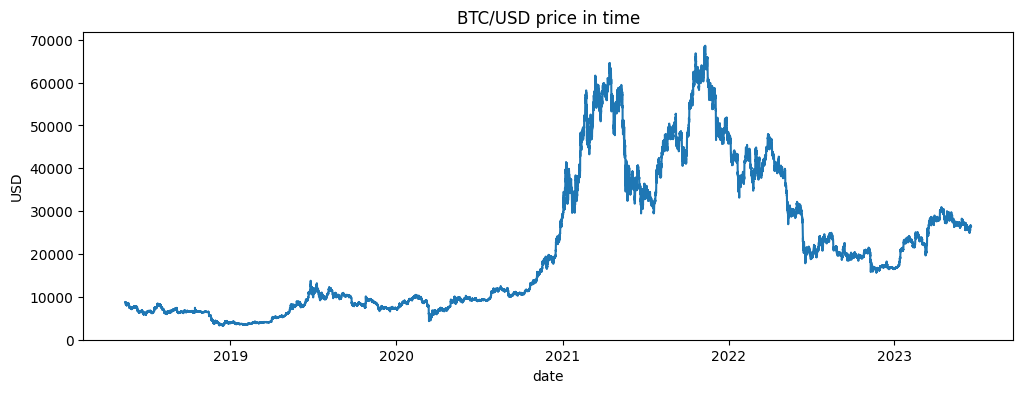

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['close'])

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')

# Displaying the plot
plt.show()

### Create Training and Test Set

#### Visualize test set

In [17]:
df_test = df.loc[(df['date'] >= '2021-11-01')].copy(deep=True)
df_train = df.loc[(df['date'] <= '2021-11-01' )].copy(deep=True)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df = df.reset_index()


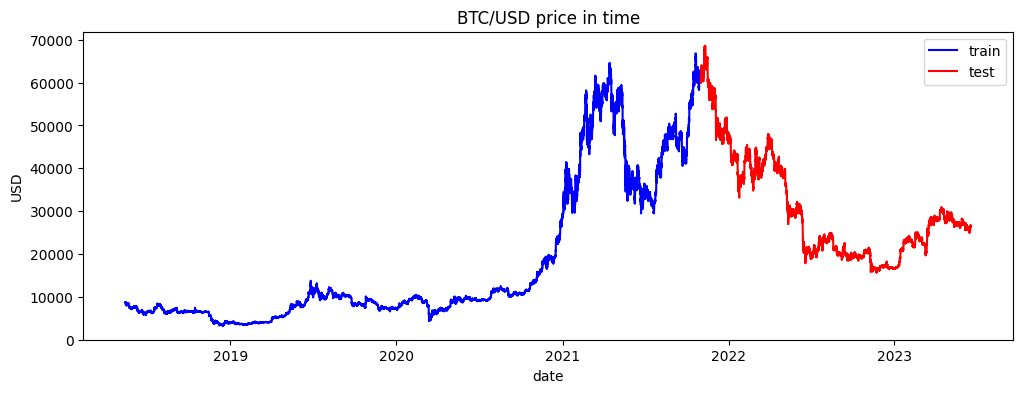

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### Create the sets

In [19]:
print("Train set consists of:", df_train.shape[0], "samples")
print("Test set consists of:", df_test.shape[0], "samples")
print("Test set is ",(df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]))*100,"of the dataset.")

Train set consists of: 30374 samples
Test set consists of: 14252 samples
Test set is  31.93653923721597 of the dataset.


## Task 1 -- Trend Prediction
For this task we consider the trend to be an uptrend (y = 1) if close[t] < open[t+1] and downtrend (y = 0) if close[t] >= open[t+1].

In [20]:
def generate_trend_prediction_set(dataset):

    data = dataset.copy(deep=True)
    l = data.shape[0]
    data['price'] = [None]*l

    for index,row in data.iterrows():
        if index+1 >= l:
            continue
        data.at[index,'price'] = data.loc[index+1]['close']

    y = data['price'].values
    data = data.drop(['price','index','date'], axis = 1)

    x = data.values[:-1]
    y = y[:-1]

    print("X has nones:",np.any(np.isnan(x)))
    print("y has nones:", np.any(np.isnan(x)))

    return x,y

In [21]:
x_train, y_train = generate_trend_prediction_set(df_train)

X has nones: False
y has nones: False


In [22]:
x_test, y_test = generate_trend_prediction_set(df_test)

X has nones: False
y has nones: False


### Normalization

In [23]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Hist Gradient Boosting Classifier

In [24]:
model = HistGradientBoostingRegressor()

In [25]:
model.fit(x_train,y_train)

HistGradientBoostingRegressor()

In [26]:
y_pred = model.predict(x_test)

In [27]:
r2_score(y_test,y_pred)

0.997426738210212

In [28]:
math.sqrt(mean_squared_error(y_test,y_pred))

609.3640493608124

In [29]:
mean_absolute_error(y_test,y_pred)

419.0750853101016

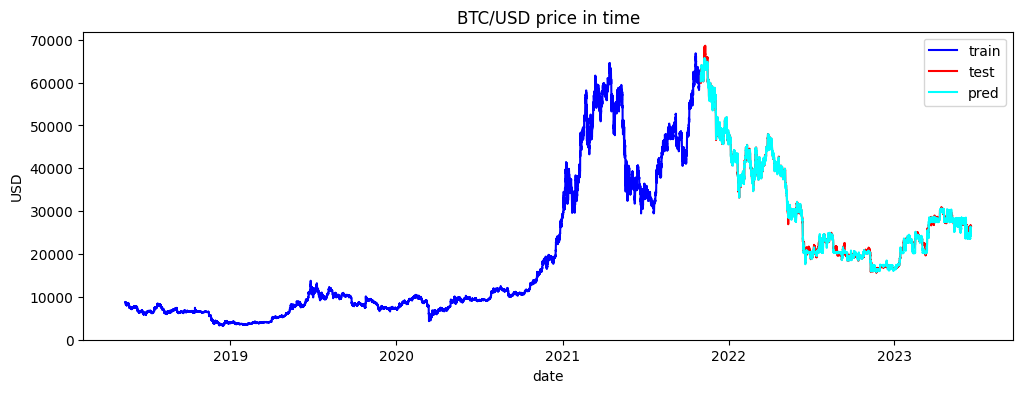

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')
plt.plot(df_test['date'][:-1], y_pred, color = 'cyan', label = 'pred')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### DNN

In [43]:
y_train_dnn = tf.convert_to_tensor(y_train, dtype=tf.float64)

In [44]:
x_train

array([[-0.03648888, -0.03379568, -0.0354767 , ..., -0.52408683,
        -0.78548392, -0.03527661],
       [-0.03555153, -0.0361319 , -0.0352029 , ..., -0.4079894 ,
        -0.78548392, -0.03540155],
       [-0.03530486, -0.03684745, -0.03931623, ..., -0.08044391,
        -0.78548392, -0.0365045 ],
       ...,
       [ 3.18258623,  3.18865894,  3.21119872, ...,  0.98425081,
         0.73917635,  3.17858327],
       [ 3.21458735,  3.19422428,  3.23590359, ...,  0.74405662,
         0.66985507,  3.17837479],
       [ 3.21157013,  3.19728216,  3.23254323, ...,  0.56455514,
         0.58446429,  3.17987368]])

In [106]:
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_shape = (x_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [107]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
checkpoint = ModelCheckpoint('best_weights2.h5', save_best_only=True)
model.compile(optimizer='Adam',loss='mean_squared_error')

In [108]:
model.fit(x_train, y_train_dnn, epochs=250, batch_size=256, validation_split=0.2, callbacks=[early_stopping, checkpoint])

Epoch 1/250


95/95 [==============================] - 1s 3ms/step - loss: 120774600.0000 - val_loss: 269881600.0000
Epoch 2/250
95/95 [==============================] - 0s 2ms/step - loss: 25090716.0000 - val_loss: 20277996.0000
Epoch 3/250
 1/95 [..............................] - ETA: 0s - loss: 11801498.0000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 0s 2ms/step - loss: 9264644.0000 - val_loss: 12294790.0000
Epoch 4/250
95/95 [==============================] - 0s 2ms/step - loss: 6291937.0000 - val_loss: 10492088.0000
Epoch 5/250
95/95 [==============================] - 0s 2ms/step - loss: 5034484.5000 - val_loss: 11621088.0000
Epoch 6/250
95/95 [==============================] - 0s 2ms/step - loss: 4278436.0000 - val_loss: 9953080.0000
Epoch 7/250
95/95 [==============================] - 0s 2ms/step - loss: 3622904.7500 - val_loss: 8448675.0000
Epoch 8/250
95/95 [==============================] - 0s 2ms/step - loss: 3250462.5000 - val_loss: 8780008.0000
Epoch 9/250
95/95 [==============================] - 0s 2ms/step - loss: 2906634.7500 - val_loss: 7668192.5000
Epoch 10/250
95/95 [==============================] - 0s 2ms/step - loss: 2719676.0000 - val_loss: 7051262.5000
Epoch 11/250
95/95 [==============================] - 0s 2ms/step - loss: 2464991.5000 - val_loss: 6578185.0000
Epoch 12

In [109]:
model.load_weights('best_weights2.h5')

In [110]:
y_pred = model.predict(x_test)

446/446 [==============================] - 0s 460us/step


In [111]:
y_pred

array([[61615.105],
       [61446.723],
       [60566.008],
       ...,
       [26624.25 ],
       [26582.621],
       [26492.008]], dtype=float32)

In [112]:
y_pred_vals = list()
for y in y_pred:
    y_pred_vals.append(y[0])

In [113]:
math.sqrt(mean_squared_error(y_test,y_pred_vals))

238.49215505040075

In [114]:
mean_absolute_error(y_test, y_pred_vals)

154.67380480941705

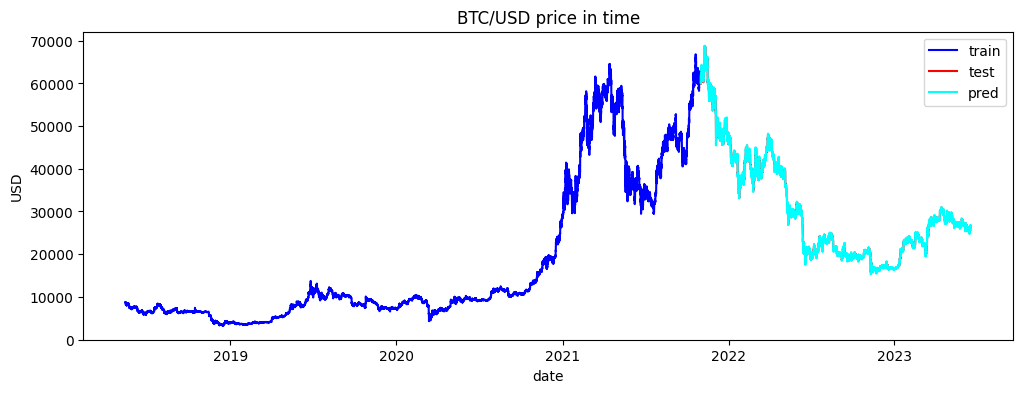

In [115]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')
plt.plot(df_test['date'][:-1], y_pred_vals, color = 'cyan', label = 'pred')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### LSTM 

In [116]:
def create_lstm_dataset(x,y):
    train_seqs = list()
    train_targets = list()

    i = 0 

    for i in range(len(x) - 24):
        seq = x[i:i+24]
        target = y[i:i+24]
        if seq.shape[0] != 24 or target.shape[0] != 24:
            continue
        train_seqs.append(seq)
        train_targets.append(target)


    train_seqs = np.array(train_seqs)
    train_targets = np.array(train_targets)

    return train_seqs,tf.convert_to_tensor(train_targets, dtype=tf.float64)


In [117]:
x_train_lstm, y_train_lstm = create_lstm_dataset(x_train,y_train)

In [118]:
x_test_lstm, y_test_lstm = create_lstm_dataset(x_test,y_test)

In [148]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),activation="relu"))
model.add(LSTM(128,activation="relu"))
model.add(Dense(1))

In [149]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True)
model.compile(loss="mean_squared_error",optimizer="adam")

In [150]:
model.fit(x_train_lstm, y_train_lstm, epochs=300, batch_size=256, validation_split=0.2, callbacks=[early_stopping, checkpoint])

Epoch 1/300
95/95 [==============================] - 8s 74ms/step - loss: 105921088.0000 - val_loss: 183716752.0000
Epoch 2/300
 2/95 [..............................] - ETA: 5s - loss: 22196394.0000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 7s 72ms/step - loss: 15234907.0000 - val_loss: 68345512.0000
Epoch 3/300
95/95 [==============================] - 7s 69ms/step - loss: 7555119.5000 - val_loss: 193657104.0000
Epoch 4/300
95/95 [==============================] - 7s 70ms/step - loss: 6399435.5000 - val_loss: 36015268.0000
Epoch 5/300
95/95 [==============================] - 7s 70ms/step - loss: 1999250.5000 - val_loss: 15278187.0000
Epoch 6/300
95/95 [==============================] - 7s 71ms/step - loss: 1020386.1875 - val_loss: 10288553.0000
Epoch 7/300
95/95 [==============================] - 7s 70ms/step - loss: 641949.8125 - val_loss: 10444500.0000
Epoch 8/300
95/95 [==============================] - 6s 68ms/step - loss: 500829.2188 - val_loss: 7734188.0000
Epoch 9/300
95/95 [==============================] - 6s 68ms/step - loss: 405494.7500 - val_loss: 7071476.0000
Epoch 10/300
95/95 [==============================] - 6s 68ms/step - loss: 393368.5625 - val_loss: 7362936.5000

In [151]:
model.load_weights('best_weights.h5')

In [152]:
y_pred = model.predict(x_test_lstm)

445/445 [==============================] - 2s 5ms/step


In [153]:
y_pred_vals = list()
for y in y_pred:
    y_pred_vals.append(y[0])

In [154]:
len(y_pred_vals)

14227

In [155]:
math.sqrt(mean_squared_error(y_test[:14227],y_pred_vals))

589.9981356332135

In [156]:
mean_absolute_error(y_test[:14227], y_pred_vals)

371.5501786927794

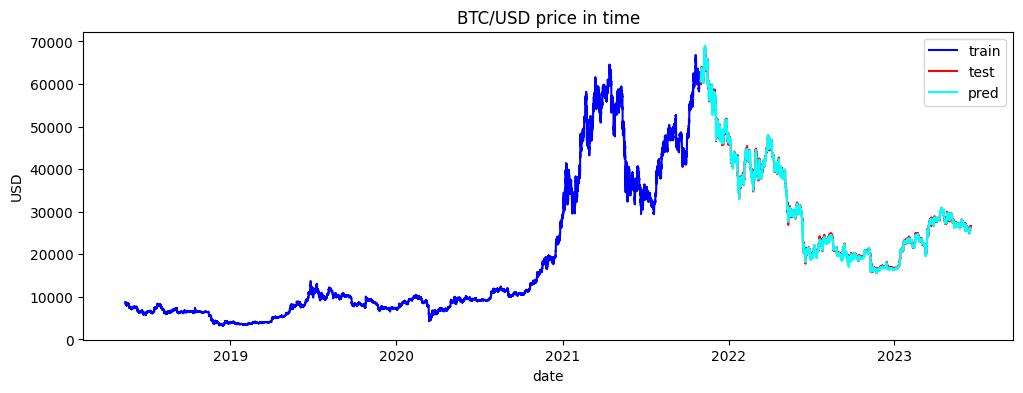

In [214]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')
plt.plot(df_test['date'][:14227], y_pred_vals, color = 'cyan', label = 'pred')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()